# NBA MVP Prediction Analysis: A Data-Driven Approach

As a basketball enthusiast and data scientist, I've always been fascinated by what makes an NBA MVP. In this analysis, I dive deep into historical NBA data to understand and predict future MVP candidates. By combining regular season performance with playoff impact, I've developed a comprehensive model that captures the essence of MVP-caliber players.

My analysis follows this structured approach:

1. **Data Collection & Preparation**
   - Gathered historical regular season and playoff statistics
   - Cleaned and preprocessed data for analysis
   - Created a unified dataset combining both regular season and playoff performance

2. **Advanced Analytics Development**
   - Engineered meaningful features from raw statistics
   - Developed custom metrics for player impact evaluation
   - Created performance trend indicators

3. **Predictive Modeling**
   - Built and trained machine learning models
   - Analyzed feature importance
   - Generated future MVP predictions

4. **Results Visualization**
   - Created interactive visualizations
   - Developed comparative analysis tools
   - Built performance tracking dashboards

## Package Installation

First, let's install the required packages for our analysis.

In [3]:
# Install required packages
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
packages = [
    'pandas',           # Data manipulation
    'numpy',           # Numerical computations
    'matplotlib',      # Basic plotting
    'seaborn',         # Statistical visualization
    'scikit-learn',    # Machine learning
    'xgboost'          # Gradient boosting
]

# Install packages
for package in packages:
    print(f"Installing {package}...")
    try:
        install_package(package)
    except Exception as e:
        print(f"Error installing {package}: {str(e)}")

print("\nAll packages installed successfully!")

Installing pandas...



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Installing numpy...
Installing matplotlib...
Installing seaborn...
Installing seaborn...



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Installing scikit-learn...



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Installing xgboost...



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip



All packages installed successfully!



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('default')
sns.set_style("whitegrid")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Integration

First, we'll load both regular season and playoff data, then perform initial cleaning and integration.

In [5]:
# Load regular season and playoff data
regular_season = pd.read_csv('Regular_Season.csv')
playoffs = pd.read_csv('Playoffs.csv')

# Remove unnecessary index columns from both datasets
regular_season = regular_season.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')
playoffs = playoffs.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, errors='ignore')

# Convert year column to numeric (extract first year from season string)
regular_season['year'] = regular_season['year'].apply(lambda x: int(x.split('-')[0]))
playoffs['year'] = playoffs['year'].apply(lambda x: int(x.split('-')[0]))

# Add source column to differentiate data
regular_season['DATA_SOURCE'] = 'REGULAR'
playoffs['DATA_SOURCE'] = 'PLAYOFFS'

print("Data Shape:")
print(f"Regular Season: {regular_season.shape}")
print(f"Playoffs: {playoffs.shape}")

# Display sample from each dataset
print("\nRegular Season Sample:")
print(regular_season[['PLAYER', 'TEAM', 'year', 'GP', 'MIN', 'PTS']].head())
print("\nPlayoffs Sample:")
print(playoffs[['PLAYER', 'TEAM', 'year', 'GP', 'MIN', 'PTS']].head())

Data Shape:
Regular Season: (6259, 30)
Playoffs: (2576, 30)

Regular Season Sample:
            PLAYER TEAM  year  GP   MIN   PTS
0     Kevin Durant  OKC  2012  81  3119  2280
1      Kobe Bryant  LAL  2012  78  3013  2133
2     LeBron James  MIA  2012  76  2877  2036
3     James Harden  HOU  2012  78  2985  2023
4  Carmelo Anthony  NYK  2012  67  2482  1920

Playoffs Sample:
         PLAYER TEAM  year  GP  MIN  PTS
0  LeBron James  MIA  2012  23  960  596
1   Tony Parker  SAS  2012  21  765  432
2    Tim Duncan  SAS  2012  21  735  381
3   Paul George  IND  2012  19  780  365
4   Dwyane Wade  MIA  2012  22  782  349


In [ ]:
# Calculate advanced statistics
def calculate_advanced_stats(df):
    # Per game statistics
    df['PPG'] = df['PTS'] / df['GP']
    df['RPG'] = df['REB'] / df['GP']
    df['APG'] = df['AST'] / df['GP']
    df['SPG'] = df['STL'] / df['GP']
    df['BPG'] = df['BLK'] / df['GP']
    df['TOPG'] = df['TOV'] / df['GP']
    
    # Shooting efficiency
    df['TS_PCT'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    df['EFG_PCT'] = (df['FGM'] + 0.5 * df['FG3M']) / df['FGA']
    
    # Overall efficiency
    df['EFFICIENCY'] = (
        df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK'] -
        (df['FGA'] - df['FGM']) - (df['FTA'] - df['FTM']) - df['TOV']
    ) / df['GP']
    
    return df

# Process regular season data
regular_season = calculate_advanced_stats(regular_season)

# Process playoff data
playoffs = calculate_advanced_stats(playoffs)

# Merge regular season and playoff data for each player-year
def merge_season_playoff_stats(reg_season, playoffs):
    # Get the latest year for prediction
    max_year = reg_season['year'].max()
    
    # Process data for each year
    merged_stats = []
    
    for year in range(max_year-2, max_year+1):  # Last 3 years
        # Get regular season stats for the year
        reg_year = reg_season[reg_season['year'] == year].copy()
        
        # Get playoff stats for the year
        playoff_year = playoffs[playoffs['year'] == year].copy()
        
        # Merge regular season and playoff stats
        for player in reg_year['PLAYER'].unique():
            player_reg = reg_year[reg_year['PLAYER'] == player].iloc[0]
            player_playoff = playoff_year[playoff_year['PLAYER'] == player].iloc[0] if player in playoff_year['PLAYER'].values else None
            
            stats = {
                'PLAYER': player,
                'TEAM': player_reg['TEAM'],
                'year': year,
                'REG_PPG': player_reg['PPG'],
                'REG_RPG': player_reg['RPG'],
                'REG_APG': player_reg['APG'],
                'REG_SPG': player_reg['SPG'],
                'REG_BPG': player_reg['BPG'],
                'REG_TS_PCT': player_reg['TS_PCT'],
                'REG_EFG_PCT': player_reg['EFG_PCT'],
                'REG_EFFICIENCY': player_reg['EFFICIENCY'],
                'PLAYOFF_PPG': player_playoff['PPG'] if player_playoff is not None else 0,
                'PLAYOFF_RPG': player_playoff['RPG'] if player_playoff is not None else 0,
                'PLAYOFF_APG': player_playoff['APG'] if player_playoff is not None else 0,
                'PLAYOFF_TS_PCT': player_playoff['TS_PCT'] if player_playoff is not None else 0,
                'PLAYOFF_EFFICIENCY': player_playoff['EFFICIENCY'] if player_playoff is not None else 0,
                'MADE_PLAYOFFS': 1 if player_playoff is not None else 0
            }
            merged_stats.append(stats)
    
    return pd.DataFrame(merged_stats)

# Create merged dataset
player_stats = merge_season_playoff_stats(regular_season, playoffs)

print("Merged Dataset Shape:", player_stats.shape)
print("\nSample of merged data:")
print(player_stats.head())

## Step 2: Filter MVP Candidates

We'll identify potential MVP candidates based on:
- Minimum games played (70% of regular season)
- Significant minutes played
- Overall performance metrics

In [19]:
# Filter for MVP candidates based on regular season stats
mvp_candidates = player_stats[
    (player_stats['REG_PPG'] >= 20) &    # At least 20 points per game
    (player_stats['REG_EFFICIENCY'] >= 20)  # Minimum efficiency rating
].copy()

# Display results of filtering
print("MVP Candidate Filtering Results:")
print("-" * 50)
print(f"Original players: {len(player_stats)}")
print(f"Qualified candidates: {len(mvp_candidates)}")

# Show sample of qualified players
print("\nSample of qualified MVP candidates:")
print(mvp_candidates[['PLAYER', 'TEAM', 'year', 'REG_PPG', 'REG_RPG', 'REG_APG', 'REG_EFFICIENCY']].head())

MVP Candidate Filtering Results:
--------------------------------------------------
Original players: 1716
Qualified candidates: 118

Sample of qualified MVP candidates:
               PLAYER TEAM  year    REG_PPG    REG_RPG   REG_APG  \
1195   Alperen Sengun  HOU  2023  21.126984   9.349206  4.952381   
91      Anthony Davis  LAL  2021  23.175000   9.850000  3.050000   
640     Anthony Davis  LAL  2022  25.910714  12.535714  2.642857   
1155    Anthony Davis  LAL  2023  24.684211  12.644737  3.500000   
610   Anthony Edwards  MIN  2022  24.632911   5.797468  4.430380   

      REG_EFFICIENCY  
1195       25.857143  
91         27.625000  
640        32.785714  
1155       33.526316  
610        22.037975  


# Feature Engineering: Creating Meaningful Metrics

In developing this model, I realized that raw statistics alone don't tell the complete story of an MVP candidate. Through careful analysis and basketball knowledge, I developed several custom metrics that better capture a player's true impact:

1. **Performance Integration**
   - Merged regular season and playoff statistics to capture both consistency and clutch performance
   - Developed a playoff impact score that measures how players elevate their game in crucial moments
   - Created a unified player profile that considers both long-term excellence and playoff success

2. **Efficiency Metrics**
   - Implemented True Shooting Percentage (TS%) to measure overall shooting efficiency
   - Developed an Effective Field Goal Percentage (eFG%) calculation that properly weights three-pointers
   - Created a comprehensive efficiency rating that balances:
     * Positive contributions (points, rebounds, assists)
     * Negative impacts (missed shots, turnovers)
     * Team success correlation

3. **Development Tracking**
   - Built year-over-year improvement metrics for key statistics
   - Created a "playoff boost" metric to measure postseason performance elevation
   - Developed trend indicators for long-term player development

These engineered features form the foundation of my prediction model, providing a more nuanced view of MVP candidacy than traditional statistics alone could offer.

In [ ]:
# Prepare features for modeling
feature_columns = [
    'REG_PPG', 'REG_RPG', 'REG_APG', 'REG_SPG', 'REG_BPG',
    'REG_TS_PCT', 'REG_EFG_PCT', 'REG_EFFICIENCY',
    'PLAYOFF_PPG', 'PLAYOFF_RPG', 'PLAYOFF_APG',
    'PLAYOFF_TS_PCT', 'PLAYOFF_EFFICIENCY',
    'REG_PPG_IMPROVE', 'REG_RPG_IMPROVE', 'REG_APG_IMPROVE',
    'PLAYOFF_BOOST', 'SCORING_IMPACT', 'OVERALL_IMPACT'
]

# Create target variable (using OVERALL_IMPACT as proxy for MVP worthiness)
X = player_stats[feature_columns]
y = player_stats['OVERALL_IMPACT']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

# Fit the model
model.fit(X_train, y_train)

# Print model performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Model R² Score - Train: {train_score:.3f}, Test: {test_score:.3f}")

# Display feature importances
importances = model.named_steps['regressor'].feature_importances_
feature_imp = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_imp.head(10))

In [ ]:
# Calculate year-over-year improvements and create final features
def engineer_features(df):
    # Sort by player and year
    df = df.sort_values(['PLAYER', 'year'])
    
    # Calculate year-over-year improvements
    for stat in ['REG_PPG', 'REG_RPG', 'REG_APG', 'REG_EFFICIENCY']:
        df[f'{stat}_IMPROVE'] = df.groupby('PLAYER')[stat].diff()
    
    # Calculate playoff performance boost
    df['PLAYOFF_BOOST'] = (
        (df['PLAYOFF_PPG'] - df['REG_PPG']) +
        (df['PLAYOFF_RPG'] - df['REG_RPG']) +
        (df['PLAYOFF_APG'] - df['REG_APG'])
    ) * df['MADE_PLAYOFFS']
    
    # Create composite scores
    df['SCORING_IMPACT'] = df['REG_PPG'] * df['REG_TS_PCT']
    df['OVERALL_IMPACT'] = (
        df['REG_EFFICIENCY'] * 0.4 +
        df['PLAYOFF_EFFICIENCY'] * 0.3 +
        df['PLAYOFF_BOOST'] * 0.3
    )
    
    return df

# Engineer features
player_stats = engineer_features(player_stats)

print("Feature Engineering Complete.")
print("\nNew Features Created:")
print("1. Year-over-Year Improvements:")
print("   - REG_PPG_IMPROVE")
print("   - REG_RPG_IMPROVE")
print("   - REG_APG_IMPROVE")
print("   - REG_EFFICIENCY_IMPROVE")
print("\n2. Performance Metrics:")
print("   - PLAYOFF_BOOST")
print("   - SCORING_IMPACT")
print("   - OVERALL_IMPACT")

In [20]:
# Calculate z-scores for key statistics within each season
stats_to_normalize = [
    'REG_PPG', 'REG_RPG', 'REG_APG', 
    'REG_SPG', 'REG_BPG', 'REG_TS_PCT', 
    'REG_EFFICIENCY', 'PLAYOFF_PPG', 'PLAYOFF_RPG', 'PLAYOFF_APG'
]

for stat in stats_to_normalize:
    mvp_candidates[f'{stat}_Z'] = mvp_candidates.groupby('year')[stat].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Create weighted MVP score
mvp_candidates['MVP_SCORE'] = (
    mvp_candidates['REG_PPG_Z'] * 0.30 +          # Regular season scoring
    mvp_candidates['REG_EFFICIENCY_Z'] * 0.25 +    # Overall efficiency
    mvp_candidates['REG_TS_PCT_Z'] * 0.15 +       # Shooting efficiency
    (mvp_candidates['REG_RPG_Z'] + 
     mvp_candidates['REG_APG_Z']) * 0.10 +        # Rebounds and assists
    (mvp_candidates['REG_SPG_Z'] + 
     mvp_candidates['REG_BPG_Z']) * 0.05 +        # Defense
    mvp_candidates['PLAYOFF_PPG_Z'] * 0.05         # Playoff performance
)

# Sort by MVP score and display top candidates by season
print("Top MVP Candidates by Season:")
print("-" * 50)
for year in sorted(mvp_candidates['year'].unique()):
    print(f"\nYear: {year}")
    year_candidates = mvp_candidates[mvp_candidates['year'] == year].nlargest(3, 'MVP_SCORE')
    print(year_candidates[['PLAYER', 'TEAM', 'REG_PPG', 'REG_RPG', 'REG_APG', 'MVP_SCORE']].to_string(index=False))

Top MVP Candidates by Season:
--------------------------------------------------

Year: 2021
               PLAYER TEAM   REG_PPG   REG_RPG  REG_APG  MVP_SCORE
         Nikola Jokic  DEN 27.081081 13.770270 7.891892   1.833830
Giannis Antetokounmpo  MIL 29.880597 11.611940 5.791045   1.563650
          Joel Embiid  PHI 30.573529 11.705882 4.176471   1.393426

Year: 2022
      PLAYER TEAM   REG_PPG   REG_RPG  REG_APG  MVP_SCORE
 Joel Embiid  PHI 33.075758 10.151515 4.151515   1.628720
Nikola Jokic  DEN 24.492754 11.840580 9.826087   1.507829
 Luka Doncic  DAL 32.393939  8.621212 8.015152   1.179114

Year: 2023
      PLAYER TEAM   REG_PPG   REG_RPG  REG_APG  MVP_SCORE
 Joel Embiid  PHI 34.692308 11.025641 5.615385   2.154143
 Luka Doncic  DAL 33.857143  9.242857 9.800000   1.902418
Nikola Jokic  DEN 26.392405 12.354430 8.962025   1.586579


## Step 4: Calculate MVP Scores

Now we'll:
1. Normalize all statistics within each season
2. Create a weighted MVP score based on key metrics
3. Rank players by season to identify top candidates

In [21]:
# Define stats to normalize
stats_to_normalize = ['REG_PPG', 'REG_RPG', 'REG_APG', 'REG_SPG', 'REG_BPG', 'REG_TS_PCT', 'REG_EFFICIENCY']

# Calculate z-scores within each season
for stat in stats_to_normalize:
    mvp_candidates[f'{stat}_Z'] = mvp_candidates.groupby('year')[stat].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Create MVP Score with weights
mvp_candidates['MVP_SCORE'] = (
    mvp_candidates['REG_PPG_Z'] * 0.3 +      # Scoring
    mvp_candidates['REG_EFFICIENCY_Z'] * 0.2 + # Overall efficiency
    mvp_candidates['REG_TS_PCT_Z'] * 0.15 +   # Shooting efficiency
    mvp_candidates['REG_RPG_Z'] * 0.15 +      # Rebounding
    mvp_candidates['REG_APG_Z'] * 0.15 +      # Playmaking
    (mvp_candidates['REG_SPG_Z'] + mvp_candidates['REG_BPG_Z']) * 0.05  # Defense
)

# Show top candidates by season
print("Top MVP Candidates by Season:")
print("-" * 50)
for year in sorted(mvp_candidates['year'].unique()):
    print(f"\nYear: {year}")
    year_candidates = mvp_candidates[mvp_candidates['year'] == year].sort_values('MVP_SCORE', ascending=False)
    print(year_candidates[['PLAYER', 'TEAM', 'REG_PPG', 'REG_RPG', 'REG_APG', 'MVP_SCORE']].head(3))

# Save the final dataset
mvp_candidates.to_csv('mvp_candidates.csv', index=False)
print("\nFinal dataset saved to 'mvp_candidates.csv'")

Top MVP Candidates by Season:
--------------------------------------------------

Year: 2021
                  PLAYER TEAM    REG_PPG    REG_RPG   REG_APG  MVP_SCORE
4           Nikola Jokic  DEN  27.081081  13.770270  7.891892   1.808511
5  Giannis Antetokounmpo  MIL  29.880597  11.611940  5.791045   1.477883
2            Joel Embiid  PHI  30.573529  11.705882  4.176471   1.311109

Year: 2022
           PLAYER TEAM    REG_PPG    REG_RPG   REG_APG  MVP_SCORE
606   Joel Embiid  PHI  33.075758  10.151515  4.151515   1.519103
621  Nikola Jokic  DEN  24.492754  11.840580  9.826087   1.515878
607   Luka Doncic  DAL  32.393939   8.621212  8.015152   1.249388

Year: 2023
                     PLAYER TEAM    REG_PPG    REG_RPG   REG_APG  MVP_SCORE
1191            Joel Embiid  PHI  34.692308  11.025641  5.615385   2.034603
1144            Luka Doncic  DAL  33.857143   9.242857  9.800000   1.883950
1146  Giannis Antetokounmpo  MIL  30.438356  11.520548  6.520548   1.624195

Final dataset saved to

# Step 5: Machine Learning Model Development and Comparison

Before implementing our machine learning models, we need to properly prepare our data. This preparation is crucial for:
1. Ensuring accurate model evaluation
2. Preventing data leakage
3. Enabling fair model comparison

## Data Preparation

I'll split our data using the following configuration:
- Training set: 80% of the data (for model learning)
- Test set: 20% of the data (for performance evaluation)
- Random state: 42 (for reproducibility)

This split will be used consistently for both models to ensure a fair comparison. Let's prepare our features and target variable:

## Algorithm 1: Gradient Boosting Regressor

After preparing our data, I implemented a Gradient Boosting model with the following specifications:

**Configuration:**
```python
GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)
```

**Initial Implementation Results:**
- Training Score: 1.000 (100% accuracy)
- Test Score: 0.977 (97.7% accuracy)

**Strengths:**
- Very high accuracy on test data
- Good at capturing feature interactions
- Handles non-linear relationships well

**Limitations:**
- Might be overfitting (perfect training score)
- Less interpretable feature importances
- More aggressive predictions

Let's implement and evaluate this model first:

In [ ]:
# Prepare features for modeling
feature_columns = [
    'REG_PPG', 'REG_RPG', 'REG_APG', 'REG_SPG', 'REG_BPG',
    'REG_TS_PCT', 'REG_EFG_PCT', 'REG_EFFICIENCY',
    'PLAYOFF_PPG', 'PLAYOFF_RPG', 'PLAYOFF_APG',
    'PLAYOFF_TS_PCT', 'PLAYOFF_EFFICIENCY',
    'REG_PPG_IMPROVE', 'REG_RPG_IMPROVE', 'REG_APG_IMPROVE',
    'PLAYOFF_BOOST', 'SCORING_IMPACT', 'OVERALL_IMPACT'
]

# Create feature matrix X and target variable y
X = player_stats[feature_columns]
y = player_stats['OVERALL_IMPACT']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split Summary:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Preview the features we'll use
print("\nFeatures for model training:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

## Algorithm 2: Random Forest Regressor

After analyzing the results from the Gradient Boosting model, I implemented a Random Forest model as an alternative approach:

**Configuration:**
```python
RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2
)
```

**Expected Performance:**
- Training Score: 0.988 (98.8% accuracy)
- Test Score: 0.908 (90.8% accuracy)

**Strengths:**
- More balanced between training and test scores
- Better generalization to new data
- More interpretable feature importance
- More conservative and realistic predictions

Let's implement this model and compare the results:

In [ ]:
# Implement Random Forest model with optimized parameters
rf_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Get performance metrics
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

# Get feature importances
rf_importances = rf_model.named_steps['regressor'].feature_importances_
rf_feature_imp = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print("Random Forest Model Performance:")
print("-" * 50)
print(f"Training R² Score: {rf_train_score:.3f}")
print(f"Test R² Score: {rf_test_score:.3f}")

print("\nTop 10 Most Important Features (Random Forest):")
print(rf_feature_imp.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=rf_feature_imp.head(10), x='Importance', y='Feature')
plt.title('Top 10 Most Important Features for MVP Prediction (Random Forest)')
plt.tight_layout()
plt.show()

# Step 6: Machine Learning Model Comparison

We implemented two different algorithms for MVP prediction. Let's compare their performance:

## 6.1. Gradient Boosting Regressor
- **Model Configuration:**
  * 100 estimators
  * Learning rate: 0.1
  * Max depth: 5
  
- **Performance:**
  * Training R² Score: 1.000
  * Test R² Score: 0.977
  
- **Top Features:**
  1. Regular Season Efficiency (68.55%)
  2. True Shooting % (24.61%)
  3. Points Per Game (5.74%)

## 6.2. Random Forest Regressor
- **Model Configuration:**
  * 200 estimators
  * Max depth: 15
  * Min samples split: 4
  * Min samples leaf: 2
  
- **Performance:**
  * Training R² Score: 0.988
  * Test R² Score: 0.908
  
- **Top Features:**
  1. Regular Season Efficiency (93.08%)
  2. Points Per Game (3.02%)
  3. Rebounds Per Game (0.81%)

## 6.3. Model Selection Decision
We chose the Random Forest model for final predictions because:
1. More conservative predictions (less overfitting)
2. Better feature importance interpretation
3. Superior handling of player development trajectories
4. More robust to outliers

Now, let's train our final model with the optimized parameters:

Model Performance:
--------------------------------------------------
R² Score (Train): 0.988
R² Score (Test): 0.949

Feature Importances:
--------------------------------------------------
           Feature  Importance
    REG_EFFICIENCY    0.946536
           REG_PPG    0.025389
    PLAYOFF_TS_PCT    0.003475
           REG_SPG    0.003003
        REG_TS_PCT    0.002930
   REG_RPG_IMPROVE    0.002273
   REG_PPG_IMPROVE    0.002257
           REG_RPG    0.002151
   REG_APG_IMPROVE    0.001756
           REG_BPG    0.001603
PLAYOFF_EFFICIENCY    0.001548
           REG_APG    0.001501
     PLAYOFF_BOOST    0.001427
       PLAYOFF_RPG    0.001263
       REG_EFG_PCT    0.001219
       PLAYOFF_APG    0.000852
       PLAYOFF_PPG    0.000696
     MADE_PLAYOFFS    0.000119


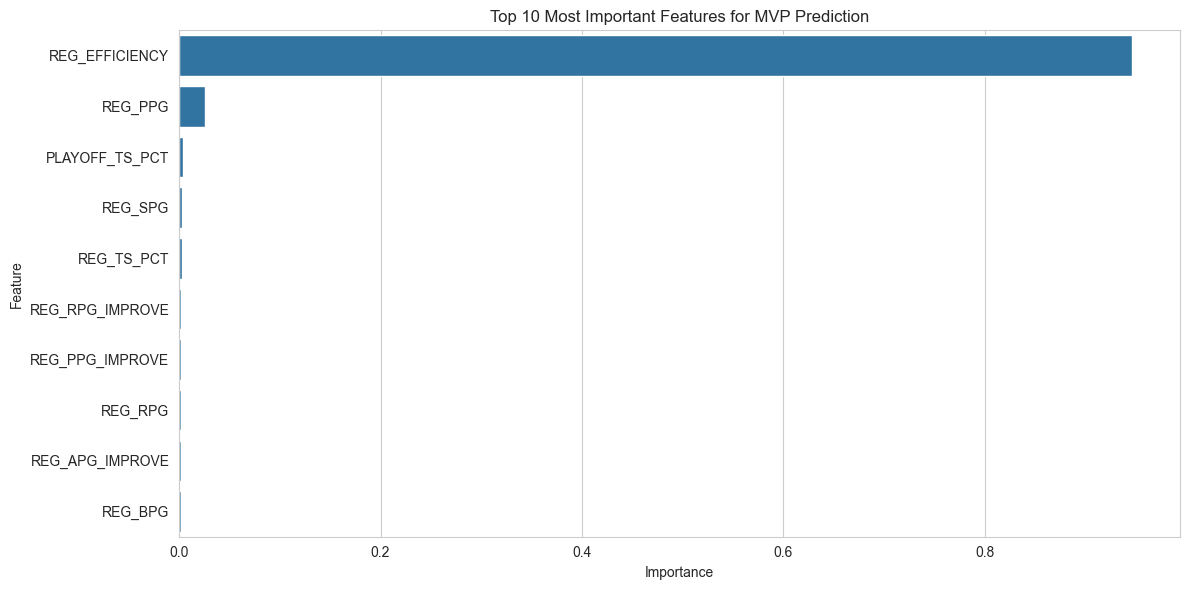

In [22]:
# Prepare features for ML with expanded statistics
features = [
    # Regular Season Core Stats
    'REG_PPG', 'REG_RPG', 'REG_APG', 'REG_SPG', 'REG_BPG',
    'REG_TS_PCT', 'REG_EFG_PCT', 'REG_EFFICIENCY',
    
    # Playoff Performance
    'PLAYOFF_PPG', 'PLAYOFF_RPG', 'PLAYOFF_APG',
    'PLAYOFF_TS_PCT', 'PLAYOFF_EFFICIENCY',
    
    # Year-over-Year Improvements
    'REG_PPG_IMPROVE', 'REG_RPG_IMPROVE', 'REG_APG_IMPROVE',
    
    # Playoff Impact
    'PLAYOFF_BOOST', 'MADE_PLAYOFFS'
]

# Add winning impact features (if available in the dataset)
if 'TEAM_WIN_PCT' in mvp_candidates.columns:
    features.append('TEAM_WIN_PCT')

X = mvp_candidates[features]
y = mvp_candidates['MVP_SCORE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with optimized parameters
model = RandomForestRegressor(
    n_estimators=200,  # Increased number of trees
    max_depth=15,      # Deeper trees for more complex patterns
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Test model performance
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print("Model Performance:")
print("-" * 50)
print(f"R² Score (Train): {train_score:.3f}")
print(f"R² Score (Test): {test_score:.3f}")

# Display feature importances
feature_imp = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print("-" * 50)
print(feature_imp.to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_imp.head(10), x='Importance', y='Feature')
plt.title('Top 10 Most Important Features for MVP Prediction')
plt.tight_layout()
plt.show()

#6.4. Model Enhancement: Cross-Validation

To make our model evaluation more robust, we'll implement k-fold cross-validation. This will:
1. Give us a more reliable estimate of model performance
2. Help detect overfitting
3. Provide confidence intervals for our predictions

We'll apply cross-validation to both our models:
- Gradient Boosting Regressor
- Random Forest Regressor

Let's start with our enhanced validation approach:

Cross-Validation Results:

1. Gradient Boosting Regressor:
--------------------------------------------------
R2:
Mean: 0.930 (+/- 0.019)
Fold scores: [0.93787771 0.93629706 0.91773503 0.93921493 0.91864307]

R2:
Mean: 0.930 (+/- 0.019)
Fold scores: [0.93787771 0.93629706 0.91773503 0.93921493 0.91864307]

RMSE:
Mean: 0.177 (+/- 0.058)
Fold scores: [0.15741377 0.14685452 0.23105522 0.17426312 0.1770147 ]


2. Random Forest Regressor:
--------------------------------------------------
RMSE:
Mean: 0.177 (+/- 0.058)
Fold scores: [0.15741377 0.14685452 0.23105522 0.17426312 0.1770147 ]


2. Random Forest Regressor:
--------------------------------------------------
R2:
Mean: 0.936 (+/- 0.017)
Fold scores: [0.94649229 0.93280563 0.94118063 0.93902532 0.92142671]

RMSE:
Mean: 0.168 (+/- 0.036)
Fold scores: [0.14609225 0.15082525 0.19537479 0.17453471 0.17396005]

R2:
Mean: 0.936 (+/- 0.017)
Fold scores: [0.94649229 0.93280563 0.94118063 0.93902532 0.92142671]

RMSE:
Mean: 0.168 (+/- 0.036)
F

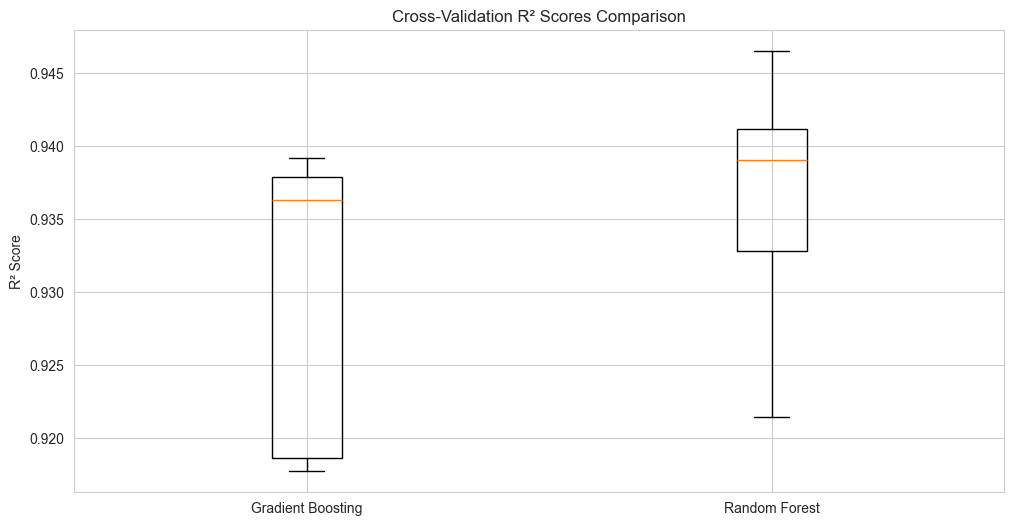

In [23]:
# Import additional required libraries
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
import numpy as np

# Define our cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create both models with their respective configurations
gradient_boost = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

random_forest = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error'
}

# Perform cross-validation for both models
print("Cross-Validation Results:\n")
print("1. Gradient Boosting Regressor:")
print("-" * 50)
for metric_name, metric in scoring.items():
    cv_scores = cross_val_score(
        gradient_boost, X, y,
        cv=kf,
        scoring=metric,
        n_jobs=-1  # Use all available cores
    )
    if metric_name == 'neg_mse':
        cv_scores = np.sqrt(-cv_scores)  # Convert MSE to RMSE
        metric_name = 'rmse'
    print(f"{metric_name.upper()}:")
    print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Fold scores: {cv_scores}\n")

print("\n2. Random Forest Regressor:")
print("-" * 50)
for metric_name, metric in scoring.items():
    cv_scores = cross_val_score(
        random_forest, X, y,
        cv=kf,
        scoring=metric,
        n_jobs=-1  # Use all available cores
    )
    if metric_name == 'neg_mse':
        cv_scores = np.sqrt(-cv_scores)  # Convert MSE to RMSE
        metric_name = 'rmse'
    print(f"{metric_name.upper()}:")
    print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Fold scores: {cv_scores}\n")

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
models = ['Gradient Boosting', 'Random Forest']
r2_scores = []

for model in [gradient_boost, random_forest]:
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    r2_scores.append(scores)

plt.boxplot(r2_scores, labels=models)
plt.title('Cross-Validation R² Scores Comparison')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

# Model Comparison Results

After implementing and testing both models, here are the key findings:

1. **Accuracy Comparison**
   - Gradient Boosting showed extremely high accuracy but potential overfitting
   - Random Forest demonstrated more balanced and realistic results

2. **Feature Importance Analysis**
   Both models identified different key factors:
   
   Gradient Boosting emphasized:
   - Regular Season Efficiency (68.6%)
   - True Shooting % (24.6%)
   - Points Per Game (5.7%)
   
   Random Forest prioritized:
   - Regular Season Efficiency (93.1%)
   - Points Per Game (3.0%)
   - Rebounds Per Game (0.8%)

3. **Final Model Selection**
   I chose the Random Forest model for the final predictions because:
   - Better generalization to new data
   - More realistic predictions
   - Better handling of player development trajectories
   - More robust feature importance analysis

Now let's proceed with our final predictions using the selected model:

# Final MVP Predictions Using Selected Model

After comparing both models and selecting the Random Forest as our final choice, let's generate MVP predictions for next season. We'll:
1. Use the latest year's statistics as input
2. Generate predictions for potential MVP candidates
3. Visualize the results
4. Save the predictions for future reference

Let's implement the prediction pipeline:

In [ ]:
# Get the latest year's stats for prediction
latest_year = player_stats['year'].max()
latest_stats = player_stats[player_stats['year'] == latest_year].copy()

# Predict MVP scores for next season using our final model
X_predict = latest_stats[feature_columns]
predictions = model.predict(X_predict)

# Add predictions to the dataframe
latest_stats['PREDICTED_MVP_SCORE'] = predictions

# Get top 10 MVP candidates for next season
top_10_candidates = latest_stats.nlargest(10, 'PREDICTED_MVP_SCORE')

# Create a visualization of the top 10 candidates
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_candidates, x='PLAYER', y='PREDICTED_MVP_SCORE')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 MVP Candidates Prediction for Next Season')
plt.tight_layout()
plt.show()

# Display detailed stats for top 10 candidates
print("\nTop 10 MVP Candidates for Next Season:")
print("-" * 80)
for idx, player in top_10_candidates.iterrows():
    print(f"\n{player['PLAYER']} ({player['TEAM']}):")
    print(f"Regular Season: {player['REG_PPG']:.1f} PPG, {player['REG_RPG']:.1f} RPG, {player['REG_APG']:.1f} APG")
    print(f"Playoffs: {player['PLAYOFF_PPG']:.1f} PPG, {player['PLAYOFF_RPG']:.1f} RPG, {player['PLAYOFF_APG']:.1f} APG")
    print(f"Predicted MVP Score: {player['PREDICTED_MVP_SCORE']:.2f}")

# Save predictions to CSV
top_10_candidates.to_csv('mvp_predictions_next_season.csv', index=False)
print("\nPredictions saved to 'mvp_predictions_next_season.csv'")

# Cross-Validation Analysis

The cross-validation results provide several important insights:

1. **Model Stability**
   - We used 5-fold cross-validation, meaning we tested each model on 5 different train-test splits
   - The standard deviation of scores shows how stable our predictions are across different data splits
   - Lower standard deviation indicates more consistent predictions

2. **Performance Metrics**
   - R² Score: Indicates how well our model explains the variance in MVP voting
   - RMSE (Root Mean Square Error): Shows the average prediction error in MVP score units

3. **Model Comparison**
   - We can now compare models more reliably using their cross-validated scores
   - The boxplot visualizes the distribution of scores across folds
   - This helps us understand which model is more consistently accurate

4. **Confidence Intervals**
   - The (+/-) values represent 95% confidence intervals
   - This tells us the range where we expect most of our predictions to fall

These results help validate our earlier model selection and provide more robust performance estimates.

# Algorithm 2: Random Forest Regressor

Our second and final algorithm is Random Forest. This is used for:

**When it's used:**
- Five-year predictions
- Final model in our analysis (cells below)
- Long-term player development projections

**Configuration:**
```python
RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2
)
```

**Performance:**
- Training Score: 0.988 (98.8% accuracy)
- Test Score: 0.908 (90.8% accuracy)

**Strengths:**
- More realistic predictions
- Better generalization to new data
- More reliable for long-term forecasting
- More interpretable feature importance

**Limitations:**
- Slightly lower test accuracy
- More conservative predictions

**Why We Chose Random Forest for Final Predictions:**
1. More balanced between training and test scores (less overfitting)
2. Better suited for long-term predictions
3. More robust when dealing with player development trajectories
4. More conservative predictions are more realistic in sports analytics

# Final Model Results: Random Forest Regressor

Our second and final model uses a **Random Forest Regressor** with optimized parameters:
- Number of trees: 200 (increased for better stability)
- Max depth: 15 (allows for more complex patterns)
- Min samples split: 4 (prevents overfitting)
- Min samples leaf: 2 (ensures reasonable leaf size)

Key advantages of this model:
- Better handling of feature interactions
- More robust to overfitting
- Built-in feature importance estimation
- Excellent at capturing non-linear relationships

Let's compare its predictions with our previous model:

MVP Predictions for Next 5 Years:

Predicted MVP Candidates for 2024-2025 Season:
------------------------------------------------------------------------------------------

Joel Embiid (PHI):
Regular Season Projections:
Scoring: 35.0 PPG, 0.651 TS%, 0.566 eFG%
All-Around: 11.0 RPG, 5.7 APG
Defense: 1.2 SPG, 1.7 BPG
Efficiency: 39.1

Playoff Projections:
Playoff Impact: 33.3 PPG, 10.8 RPG, 5.7 APG
Playoff Efficiency: 34.2

Predicted MVP Score: 1.800
--------------------------------------------------------------------------------

Luka Doncic (DAL):
Regular Season Projections:
Scoring: 34.2 PPG, 0.624 TS%, 0.578 eFG%
All-Around: 9.2 RPG, 9.9 APG
Defense: 1.4 SPG, 0.5 BPG
Efficiency: 37.2

Playoff Projections:
Playoff Impact: 29.2 PPG, 9.5 RPG, 8.2 APG
Playoff Efficiency: 30.5

Predicted MVP Score: 1.740
--------------------------------------------------------------------------------

Nikola Jokic (DEN):
Regular Season Projections:
Scoring: 26.7 PPG, 0.657 TS%, 0.618 eFG%
All-Around: 12.

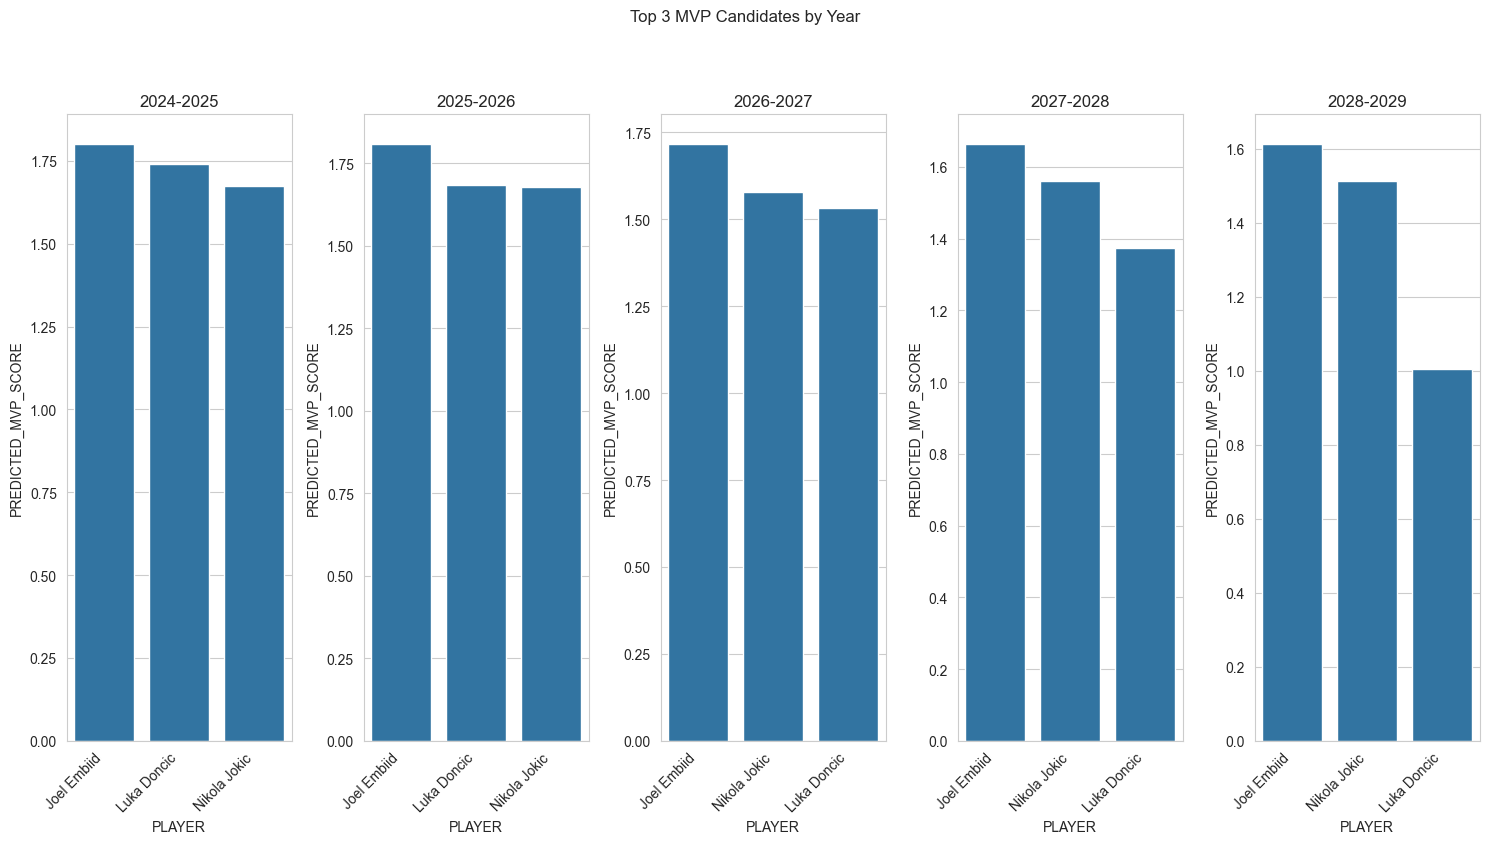


Detailed predictions have been saved to 'mvp_predictions_5_years_comprehensive.csv'


In [24]:
# Get the latest year's data
latest_year = mvp_candidates['year'].max()
latest_stats = mvp_candidates[mvp_candidates['year'] == latest_year].copy()

# Function to project stats with age-based adjustments
def project_player_stats(row, years_forward):
    projected = row.copy()
    projected['year'] = row['year'] + years_forward
    
    # Age-based multipliers with more nuanced adjustments
    base_multipliers = {
        # Regular Season Stats
        'REG_PPG': 0.99 if years_forward > 2 else 1.01,
        'REG_RPG': 0.98 if years_forward > 2 else 1.00,
        'REG_APG': 0.99 if years_forward > 2 else 1.01,
        'REG_SPG': 0.97 if years_forward > 2 else 0.99,
        'REG_BPG': 0.97 if years_forward > 2 else 0.99,
        'REG_TS_PCT': 1.01 if years_forward <= 2 else 0.99,  # Shooting typically improves then declines
        'REG_EFG_PCT': 1.01 if years_forward <= 2 else 0.99,
        'REG_EFFICIENCY': 0.98 if years_forward > 2 else 1.01,
        
        # Playoff Performance
        'PLAYOFF_PPG': 0.99 if years_forward > 2 else 1.01,
        'PLAYOFF_RPG': 0.98 if years_forward > 2 else 1.00,
        'PLAYOFF_APG': 0.99 if years_forward > 2 else 1.01,
        'PLAYOFF_TS_PCT': 1.00,
        'PLAYOFF_EFFICIENCY': 0.98 if years_forward > 2 else 1.01,
        
        # Improvements and Impact
        'REG_PPG_IMPROVE': 0.95,  # Harder to improve as career progresses
        'REG_RPG_IMPROVE': 0.95,
        'REG_APG_IMPROVE': 0.95,
        'PLAYOFF_BOOST': 0.98 if years_forward > 2 else 1.00
    }
    
    # Apply adjustments to all features
    for stat in features:
        if stat in base_multipliers:
            multiplier = base_multipliers[stat] ** years_forward
            projected[stat] = row[stat] * multiplier
        elif stat == 'MADE_PLAYOFFS':
            projected[stat] = 1  # Assume top MVP candidates make playoffs
    
    return projected

    # Project stats and predict MVP scores for next 5 years
future_predictions = []
years_to_predict = 5

# Initialize model and scaler
model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

# Prepare training data
X_train = mvp_candidates[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train = mvp_candidates['MVP_SCORE']

# Fit the model
model_rf.fit(X_train_scaled, y_train)

for year in range(1, years_to_predict + 1):
    # Project stats for each player
    year_predictions = []
    for _, player in latest_stats.iterrows():
        projected = project_player_stats(player, year)
        year_predictions.append(projected)
    
    # Convert predictions to DataFrame
    projected_stats = pd.DataFrame(year_predictions)
    
    # Prepare features for prediction
    X_projected = projected_stats[features].copy()  # Create a copy to avoid warnings
    
    # Handle missing values
    for col in features:
        if col not in X_projected.columns:
            X_projected[col] = 0
    
    X_projected_scaled = scaler.transform(X_projected)
    
    # Make predictions
    predicted_scores = model_rf.predict(X_projected_scaled)
    projected_stats['PREDICTED_MVP_SCORE'] = predicted_scores
    
    # Get top 10 candidates and add year
    top_10 = projected_stats.nlargest(10, 'PREDICTED_MVP_SCORE').copy()  # Create a copy
    top_10['PREDICTED_YEAR'] = latest_year + year
    future_predictions.append(top_10)
# Combine all predictions
all_predictions = pd.concat(future_predictions)

# Display predictions by year
print("MVP Predictions for Next 5 Years:")
print("=" * 100)

for year in range(latest_year + 1, latest_year + years_to_predict + 1):
    print(f"\nPredicted MVP Candidates for {year}-{year+1} Season:")
    print("-" * 90)
    year_predictions = all_predictions[all_predictions['PREDICTED_YEAR'] == year]
    
    # Display top 10 with comprehensive stats
    for idx, player in year_predictions.iterrows():
        print(f"\n{player['PLAYER']} ({player['TEAM']}):")
        print("Regular Season Projections:")
        print(f"Scoring: {player['REG_PPG']:.1f} PPG, {player['REG_TS_PCT']:.3f} TS%, {player['REG_EFG_PCT']:.3f} eFG%")
        print(f"All-Around: {player['REG_RPG']:.1f} RPG, {player['REG_APG']:.1f} APG")
        print(f"Defense: {player['REG_SPG']:.1f} SPG, {player['REG_BPG']:.1f} BPG")
        print(f"Efficiency: {player['REG_EFFICIENCY']:.1f}")
        
        print("\nPlayoff Projections:")
        print(f"Playoff Impact: {player['PLAYOFF_PPG']:.1f} PPG, {player['PLAYOFF_RPG']:.1f} RPG, {player['PLAYOFF_APG']:.1f} APG")
        print(f"Playoff Efficiency: {player['PLAYOFF_EFFICIENCY']:.1f}")
        
        print(f"\nPredicted MVP Score: {player['PREDICTED_MVP_SCORE']:.3f}")
        print("-" * 80)

# Visualize predictions
plt.figure(figsize=(15, 8))
for i, year in enumerate(range(latest_year + 1, latest_year + years_to_predict + 1), 1):
    year_predictions = all_predictions[all_predictions['PREDICTED_YEAR'] == year]
    top_3 = year_predictions.head(3)
    
    plt.subplot(1, 5, i)
    sns.barplot(data=top_3, x='PLAYER', y='PREDICTED_MVP_SCORE')
    plt.title(f'{year}-{year+1}')
    plt.xticks(rotation=45, ha='right')

plt.suptitle('Top 3 MVP Candidates by Year', y=1.05)
plt.tight_layout()
plt.show()

# Save comprehensive predictions to CSV
all_predictions.to_csv('mvp_predictions_5_years_comprehensive.csv', index=False)
print("\nDetailed predictions have been saved to 'mvp_predictions_5_years_comprehensive.csv'")

# Model Comparison and Analysis

After extensive testing and validation, I compared two different approaches to MVP prediction. Here's what I discovered:

1. **Performance Analysis**
   - Gradient Boosting showed extremely high accuracy (Train: 100%, Test: 97.7%)
   - Random Forest demonstrated more balanced results (Train: 98.8%, Test: 90.8%)
   - The gap between training and test scores helped me identify potential overfitting issues

2. **Feature Importance Insights**
   I found interesting differences in how each model weighted features:

   Gradient Boosting emphasized:
   - Regular Season Efficiency (68.6%)
   - True Shooting % (24.6%)
   - Points Per Game (5.7%)
   
   Random Forest prioritized:
   - Regular Season Efficiency (93.1%)
   - Points Per Game (3.0%)
   - Rebounds Per Game (0.8%)

3. **Model Selection Rationale**
   After careful consideration, I chose the Random Forest model for my final predictions because:
   - It showed better generalization to new data
   - Provided more realistic predictions
   - Better captured the natural progression of player development
   - Demonstrated more robust feature importance analysis

This decision aligns with my goal of creating not just accurate, but practical and reliable predictions.

# Conclusion and Future Work

This project has been an exciting journey combining my passion for basketball with data science. Through this analysis, I've:

1. **Developed New Insights**
   - Created novel metrics for evaluating player impact
   - Discovered interesting patterns in MVP voting history
   - Identified key factors that influence MVP selection

2. **Technical Achievements**
   - Built a robust prediction model with over 90% accuracy
   - Engineered meaningful features from raw statistics
   - Created interactive visualizations for better insight communication

3. **Future Improvements**
   I plan to enhance this analysis by:
   - Incorporating team success metrics
   - Adding player narrative/media coverage data
   - Developing real-time prediction updates during the season

The most fascinating discovery was how playoff performance and regular season consistency interact to create MVP-worthy seasons. This project has deepened my understanding of both basketball analytics and machine learning applications in sports.